In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.integrate import simps
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

from mne import Epochs, pick_types, events_from_annotations, EpochsArray, create_info, read_epochs
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch, psd_array_multitaper, stft
import seaborn as sns
from tqdm import tqdm

In [2]:
source_epochs = read_epochs('preprocessed_data/source_epochs-epo.fif', preload=True)
source_data = source_epochs.get_data()
source_data.shape

Reading /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/ml/preprocessed_data/source_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
4657 matching events found
No baseline correction applied
0 projection items activated


(4657, 4, 801)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


WARNING    /Users/anushmutyala/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
 [py.warnings]


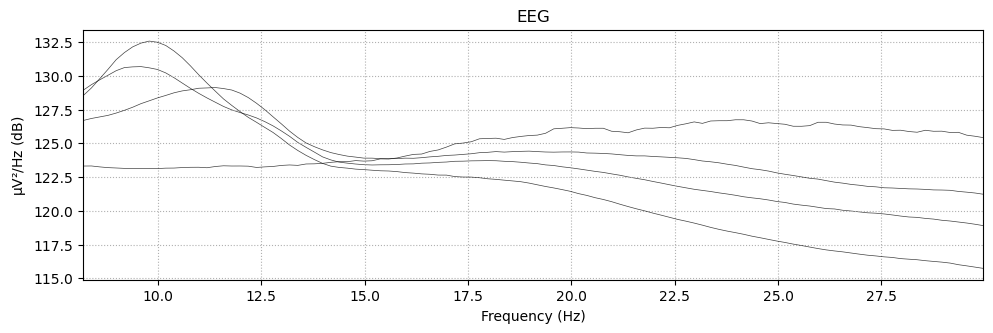

In [29]:
source_epochs.plot_psd(fmin=8, fmax=30, average=False, spatial_colors=False, n_jobs=1)

In [56]:
config = {
    "snn_config": {
        "sim_time": 10000,
        "time_step": 1,
        "mode": "dft",
        "framework": "numpy",
        "current_decay": 0,
    },
    "data": {
        "samples_per_chirp": source_data.shape[-1], # samples per channel
        "chirps_per_frame": 1,
        "antennas": 1,
        "nframes": 1
    }
    
}

print(config["data"]["samples_per_chirp"])

801


In [57]:
import spikingFT.startup
sim_handler = spikingFT.startup.custom_run(source_data, config, autorun=False)

In [58]:
output = sim_handler.run(0)
real_spikes = output[:, 0] 
imag_spikes = output[:, 1]

In [59]:
nsamples = config["data"]["samples_per_chirp"]
# Remove offset bin and negative spectrum. They do not contain relevant information
sft_real = real_spikes[1:int(nsamples/2)]
sft_imag = imag_spikes[1:int(nsamples/2)]
# Normalize between -1 and 1
sft_max = np.max(np.abs(np.hstack([sft_real, sft_imag])))
sft_real = real_spikes / sft_max
sft_imag = imag_spikes / sft_max
sft_modulus = np.sqrt(sft_real**2 + sft_imag**2)
sft_modulus = np.log10(9*sft_modulus/sft_modulus.max()+1)


In [60]:
data = sim_handler.raw_data[0, 0, :]
norm_data = data - data.min()
norm_data /= norm_data.max()
norm_data = (norm_data-0.5) * 2
ft_np = np.fft.fft(norm_data) / (nsamples/2)
ft_real = ft_np.real[1:int(nsamples/2)]
ft_imag = ft_np.imag[1:int(nsamples/2)]
ft_modulus = np.abs(ft_np)[1:int(nsamples/2)]

Text(0.5, 1.0, 'NumPy FFT')

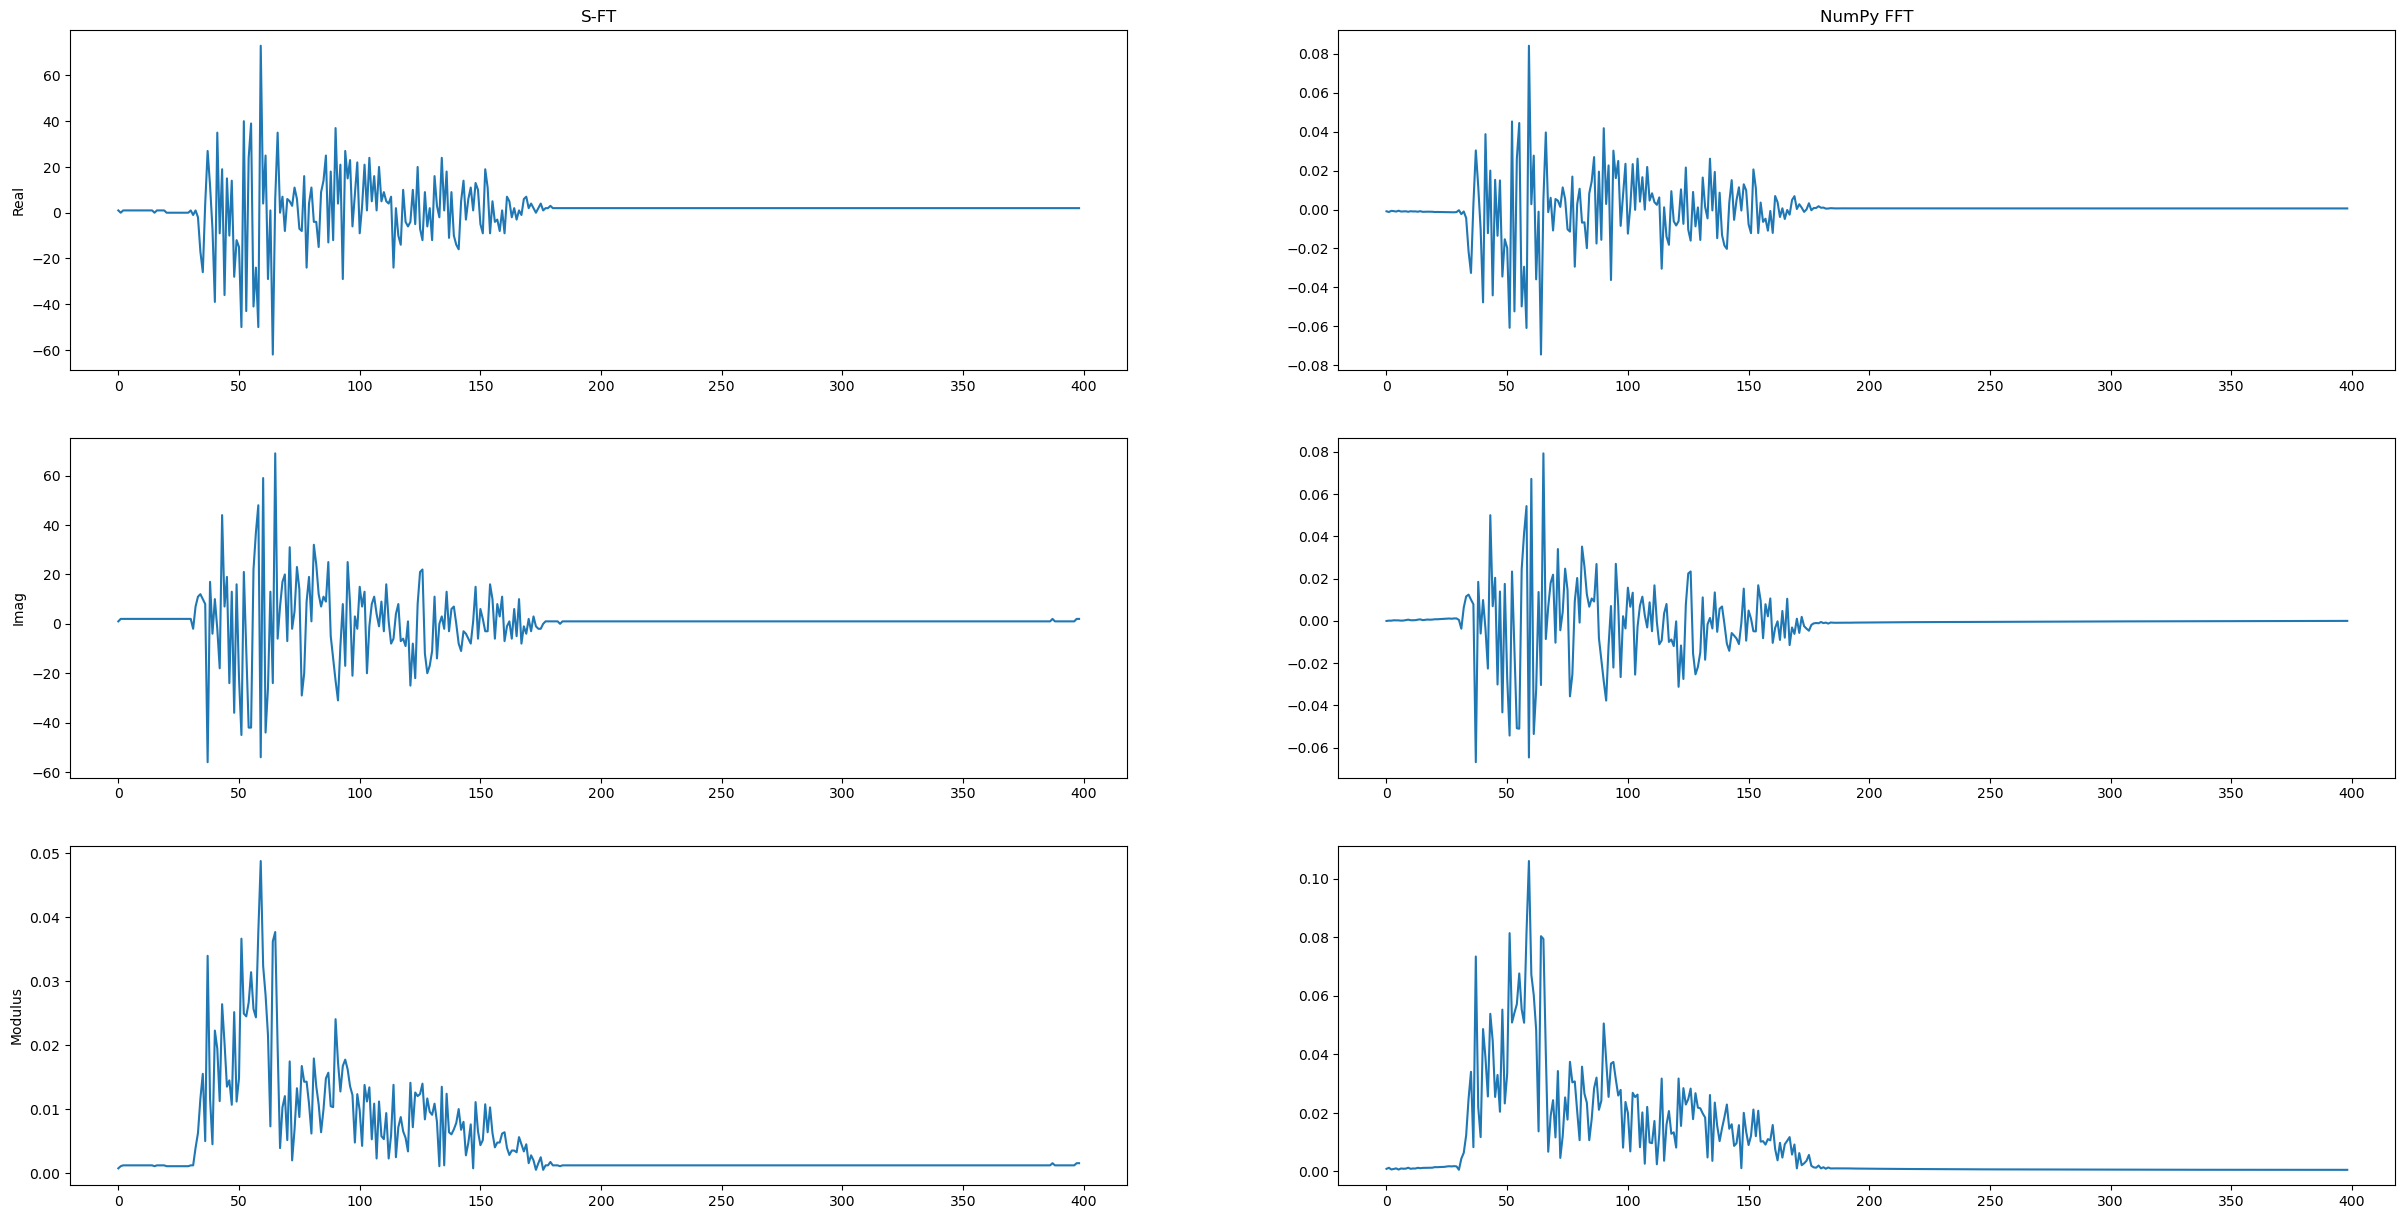

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (30, 15))
axes[0,0].plot(real_spikes[1:nsamples//2])
axes[0,0].set_ylabel("Real")
axes[1,0].plot(imag_spikes[1:nsamples//2])
axes[1,0].set_ylabel("Imag")
axes[2,0].plot(sft_modulus[1:nsamples//2])
axes[2,0].set_ylabel("Modulus")
axes[0,0].set_title("S-FT")

axes[0,1].plot(ft_real)
axes[1,1].plot(ft_imag)
axes[2,1].plot(ft_modulus)
axes[0,1].set_title("NumPy FFT")